In [1]:


import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog

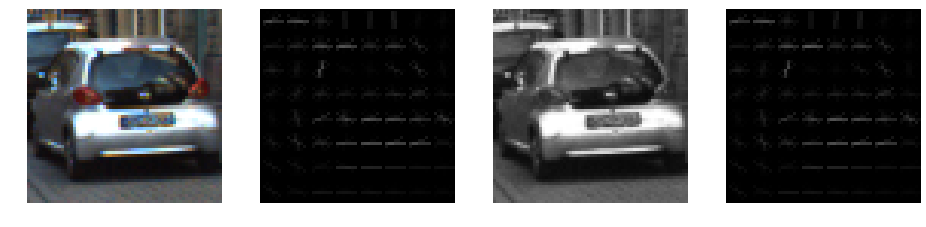

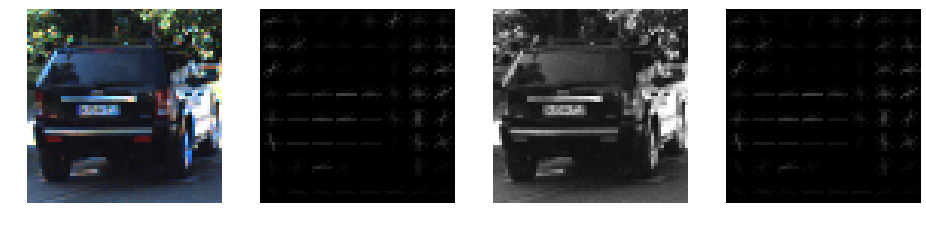

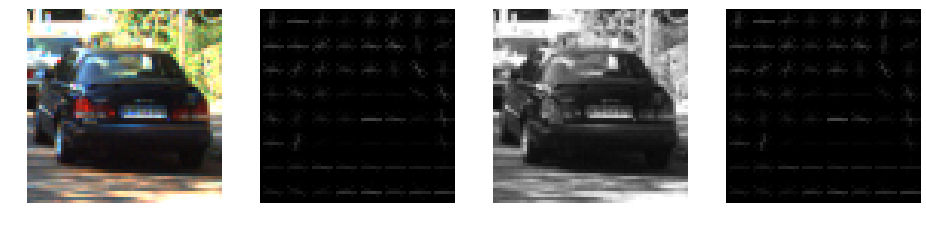

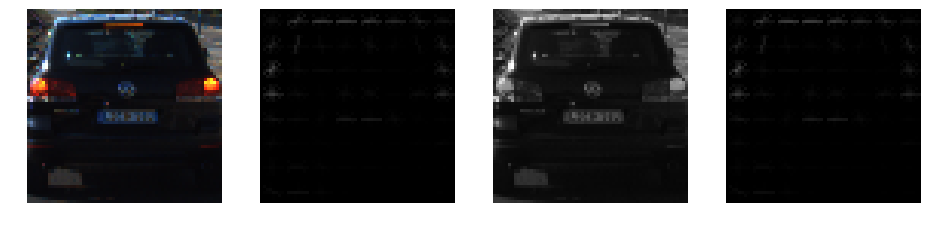

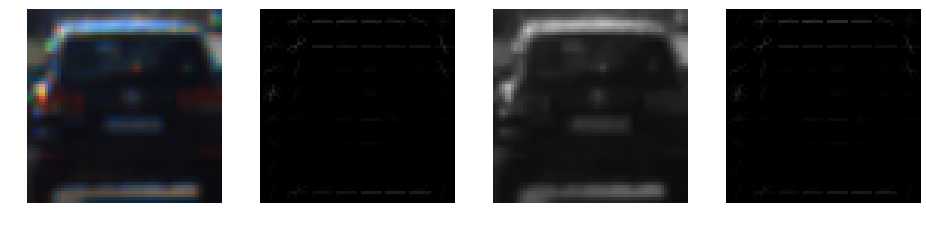

In [3]:
# show test images 
import random

from features import hog_features
from utils import _gray_to_RGB, grid_display

grid_images = []

for img_path in random.sample(vehicles, 5):
    _img = mpimg.imread(img_path)
    grid_images.append(
        _img
    )
    _gray_img = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    _, _hog_image = hog_features(_gray_img, 9, 8, 3, vis=True, feature_vec=False)
    grid_images.append(_gray_to_RGB(np.array(_hog_image, dtype=np.float32)))
    
    _hls = cv2.cvtColor(_img, cv2.COLOR_RGB2HLS)
    
    grid_images.append(
        _gray_to_RGB(_hls[:, :, 1])
    )
    
    _, _hls_image1 = hog_features(_hls[:, :, 1], 9, 8, 3, vis=True, feature_vec=False)
    grid_images.append(_gray_to_RGB(np.array(_hls_image1, dtype=np.float32)))

    
grid_display(grid_images, no_of_columns=4, figsize=(16, 16))

<Figure size 720x720 with 0 Axes>

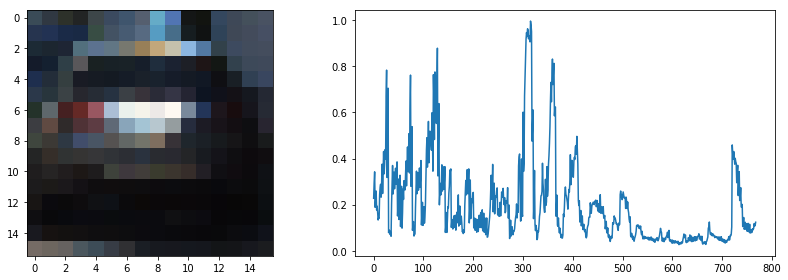

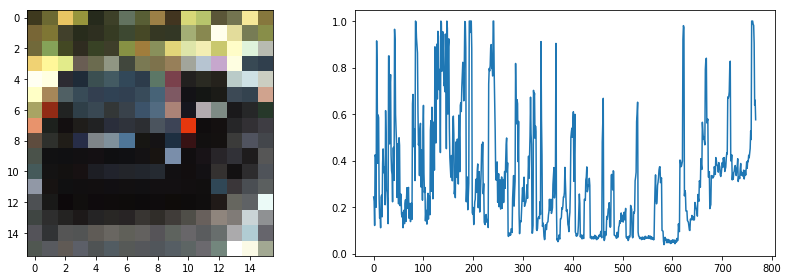

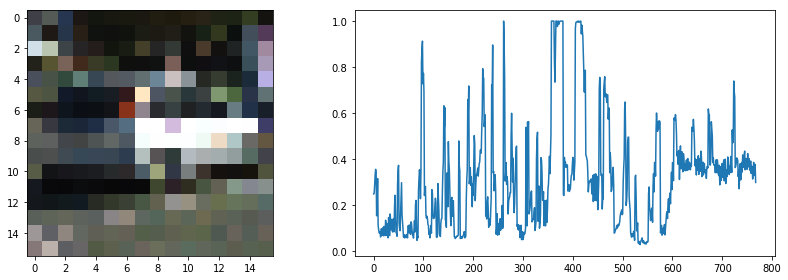

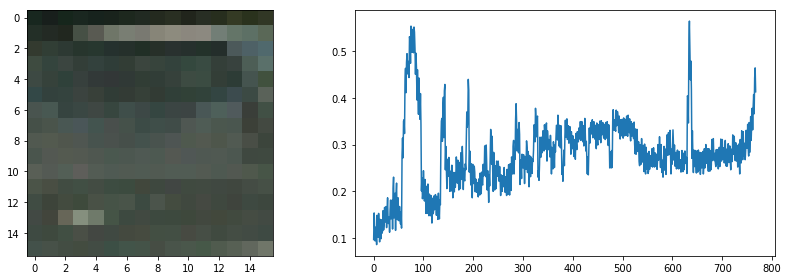

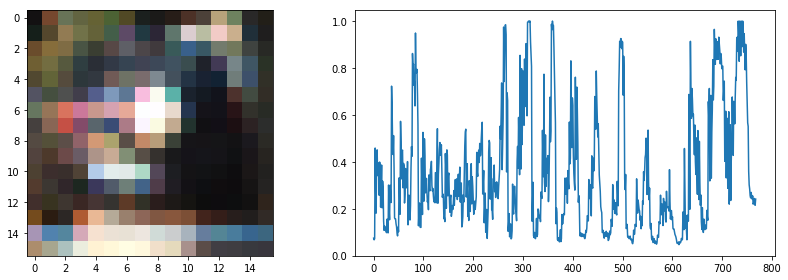

In [4]:
from features import bin_spatial_features

grid_images = []

fig = plt.figure(figsize=(10, 10))

for img_path in random.sample(vehicles, 5):
    _img = mpimg.imread(img_path)

    feature_vec = bin_spatial_features(_img, (16, 16))
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.imshow(cv2.resize(_img, (16, 16)))
    plt.subplot(122)
    plt.plot(feature_vec)
    fig.tight_layout()


In [3]:
from model import train_model

train_model()

# LUV0 - 97 %
# LUVALL - 0.9876 %
# YCrCb0 - 0.972 
# YCrCbALL - 0.9896


/Users/misiek/Programming/udacity/CarND-Vehicle-Detection/utils.py:4: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('TkAgg')


Examples lenght: 14208
Feature vector length: 6108
4.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
Saving model ....
Saving scaler .....


# Sliding window

/Users/misiek/Programming/udacity/CarND-Vehicle-Detection/utils.py:6: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('TkAgg')


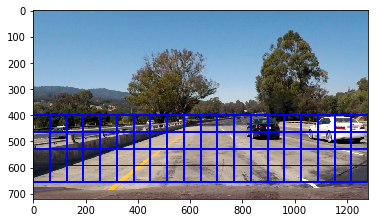

In [2]:


from frame import slide_window
from utils import draw_boxes

_img = mpimg.imread('test_images/test1.jpg')
windows = slide_window(_img, x_start_stop=[None, None], y_start_stop=[400, 700],
                       xy_window=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(_img, windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)


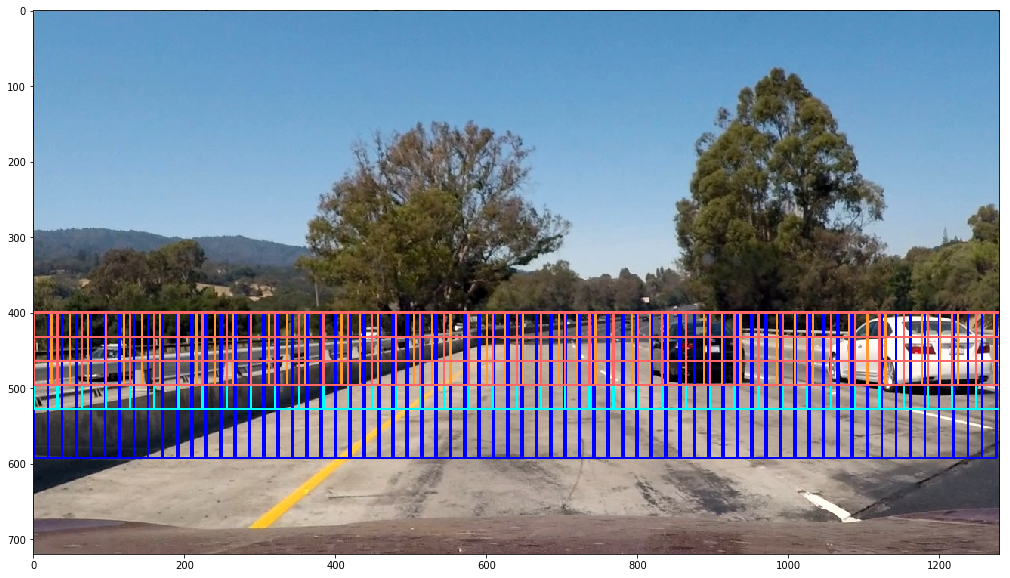

In [3]:
from frame import slide_window

_img2 = mpimg.imread('test_images/test1.jpg')

windows192 = slide_window(_img2, y_start_stop=[400, 600], xy_window=(192, 192), xy_overlap=(0.9, 0.9))
windows128 = slide_window(_img2, y_start_stop=[400, 540], xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows96 = slide_window(_img2, y_start_stop=[400, 500], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows64 = slide_window(_img2, y_start_stop=[400, 500], xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows_all_sizes = windows64 + windows96 + windows128 + windows192

bboxed_img = draw_boxes(_img2, windows192, thick=2)
bboxed_img = draw_boxes(bboxed_img, windows128, (0, 255, 255), thick=2)
bboxed_img = draw_boxes(bboxed_img, windows96, (255, 153, 51), thick=2)
bboxed_img = draw_boxes(bboxed_img, windows64, (255, 102, 102), thick=2)

plt.figure(figsize=(20, 10))
plt.imshow(bboxed_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


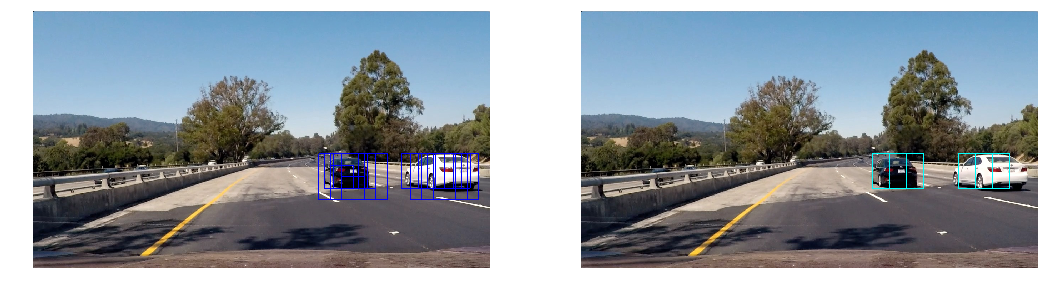

In [48]:
import numpy as np
import matplotlib.image as mpimg
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from frame import search_windows, slide_window
from utils import draw_boxes, grid_display
from model import Config

_img = mpimg.imread('test_images/test4.jpg')
_img = _img.astype(np.float32)/255

windows_same_size = slide_window(_img, x_start_stop=[None, None], y_start_stop=[400, 700],
                       xy_window=(96, 96), xy_overlap=(0.5, 0.5))

clf = joblib.load('svc.joblib')
scaler = joblib.load('scaler.joblib')

on_windows1 = search_windows(
    _img,
    windows_all_sizes,
    clf,
    scaler,
    **Config.to_kwargs()
)

on_windows2 = search_windows(
    _img,
    windows_same_size,
    clf,
    scaler,
    **Config.to_kwargs()
)


window_img1 = draw_boxes(_img, on_windows1, color=(0, 0, 255), thick=2)
window_img2 = draw_boxes(_img, on_windows2, color=(0, 200, 255), thick=2)


grid_display(
    [window_img1, window_img2],
    figsize=(18, 14)
)


In [63]:

from utils import convert_color
from features import hog_features as get_hog_features, color_hist_features, bin_spatial_features


def find_cars(
        img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
        cell_per_block, spatial_size, hist_bins
):
    
    boxes = []
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1

    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial_features(subimg, size=spatial_size)
            hist_features = color_hist_features(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                boxes.append(
                    (
                        (xbox_left, ytop_draw + ystart),
                        (xbox_left + win_draw, ytop_draw + win_draw + ystart)
                    )
                )
                
    return boxes


In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

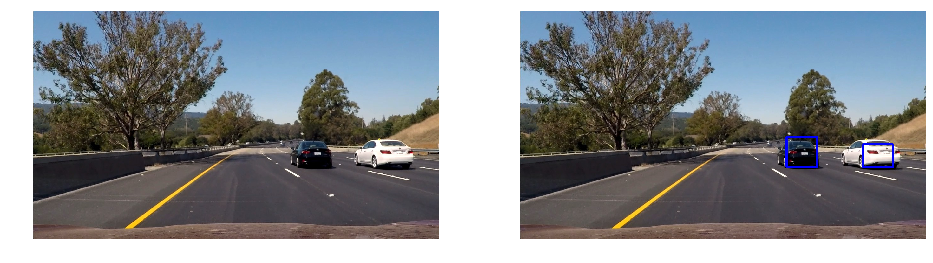

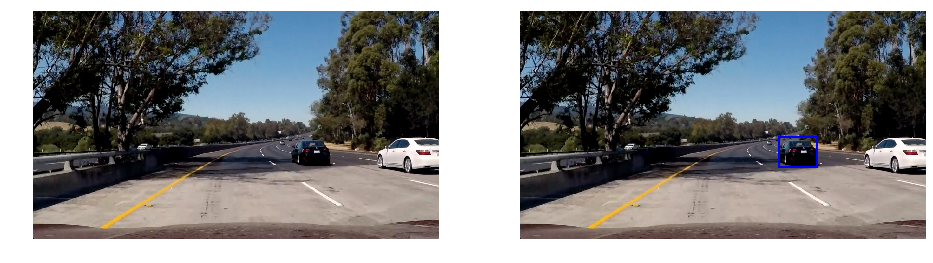

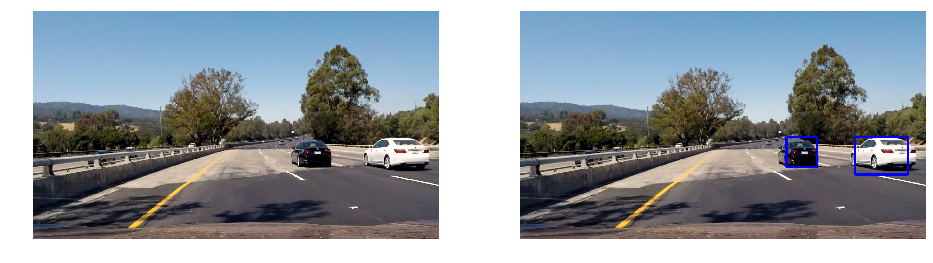

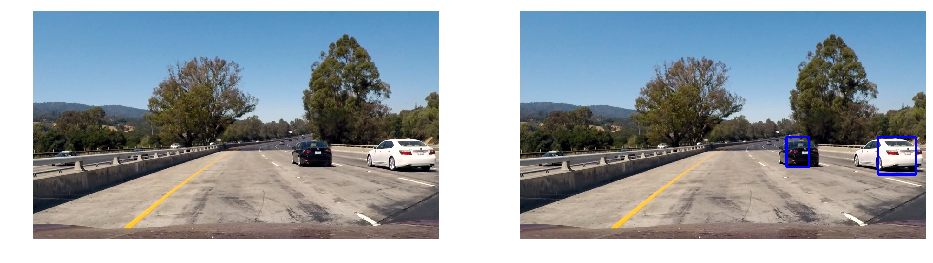

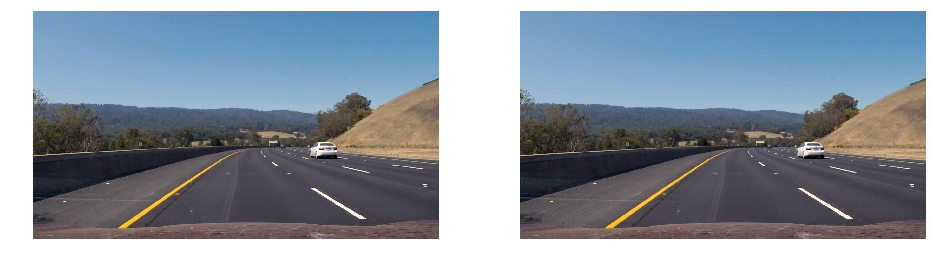

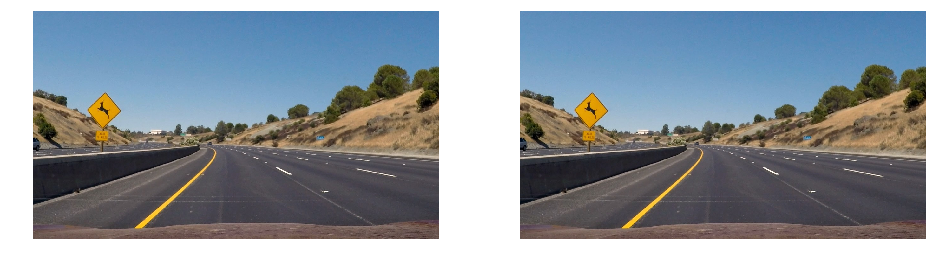

In [67]:
from glob import glob
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from model import Config
from utils import grid_display, _gray_to_RGB

test_images = glob('test_images/*.jpg')
output_images = []

svc = joblib.load('svc.joblib')
scaler = joblib.load('scaler.joblib')

cmap = plt.get_cmap('jet')

for _image in test_images:
    _img5 = mpimg.imread(_image)

    boxes = find_cars(
        _img5, 350, 660, 1.5, svc, scaler, orient=Config.orient, pix_per_cell=Config.pix_per_cell,
        cell_per_block=Config.cell_per_block, spatial_size=Config.spatial_size, hist_bins=Config.hist_bins
    )

    heat = np.zeros_like(_img5[:, :, 0]).astype(np.float)
    heat = add_heat(heat, boxes)
    heat = apply_threshold(heat, 3)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    
    rgba_img = cmap(heatmap)
    rgb_img = np.delete(rgba_img, 3, 2)
    
    output_images.append(
        _img5
    )
    output_images.append(
        draw_labeled_bboxes(np.copy(_img5), labels)
    )
    

grid_display(output_images, no_of_columns=2, figsize=(16, 16))


In [51]:

from scipy.ndimage.measurements import label

clf = joblib.load('svc.joblib')
scaler = joblib.load('scaler.joblib')


# pipeline for the movie process 
def process_image(image):
    boxes = find_cars(
        image, 400, 660, 1.5, svc, scaler, orient=Config.orient, pix_per_cell=Config.pix_per_cell,
        cell_per_block=Config.cell_per_block, spatial_size=Config.spatial_size, hist_bins=Config.hist_bins
    )

    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heat = add_heat(heat, boxes)
    heat = apply_threshold(heat, 3)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(image), labels)


class ProcessImage:
    previous_heatmaps = []
    heatmap_weights = [0.6, 0.5, 0.3, 0.2, 0.15]
    
    def __init__(self, use_history_frames=False, threshold=3):
        self.use_history_frames = use_history_frames
        self.threshold = threshold

    def process(self, image_org):
        
        image = image_org.astype(np.float32)/255
    
        boxes = search_windows(
            image,
            windows_all_sizes,
            clf,
            scaler,
            **Config.to_kwargs()
        )
    
        heat = np.zeros_like(image[:, :, 0]).astype(np.float)
        heat = add_heat(heat, boxes)
        
        if self.use_history_frames:
            if len(self.previous_heatmaps) > 5:
                self.previous_heatmaps.pop(0)

            sum_heat = heat
            for _id, _heatmap in enumerate(self.previous_heatmaps):
                sum_heat += (_heatmap*self.heatmap_weights[_id])

            self.previous_heatmaps.append(heat)
            
            heat = sum_heat
        
        heat = apply_threshold(heat, self.threshold)
        heatmap = np.clip(heat, 0, 255)
        
#         if self.use_history_frames:
#             if len(self.previous_heatmaps) > 5:
#                 self.previous_heatmaps.pop(0)

#             sum_heatmaps = heatmap
#             for _id, _heatmap in enumerate(self.previous_heatmaps):
#                 sum_heatmaps += (_heatmap*self.heatmap_weights[_id])

#             self.previous_heatmaps.append(heatmap)
        
        labels = label(heatmap)

        return draw_labeled_bboxes(image_org, labels)


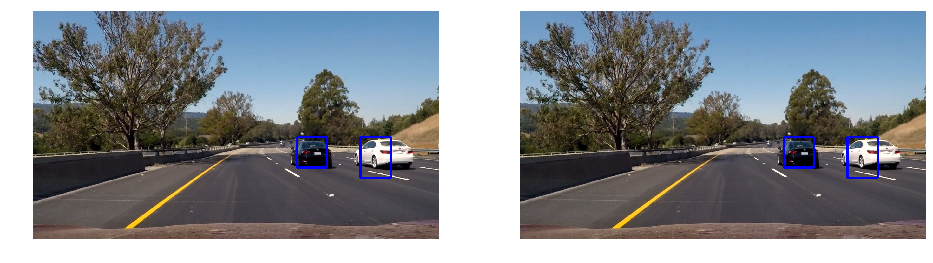

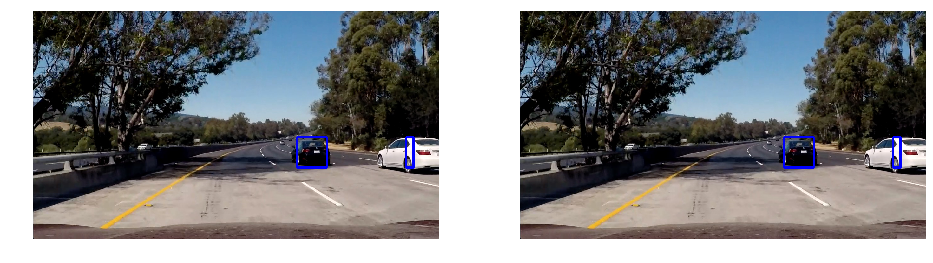

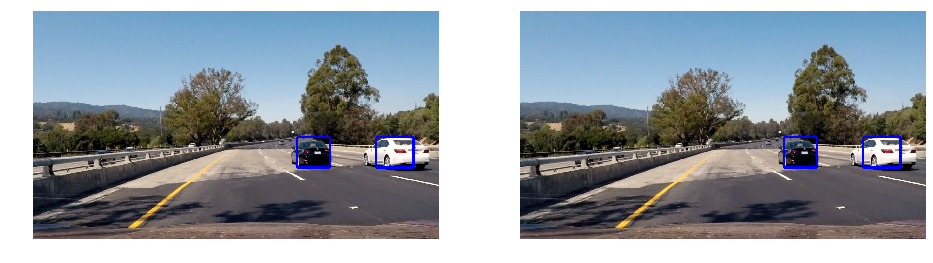

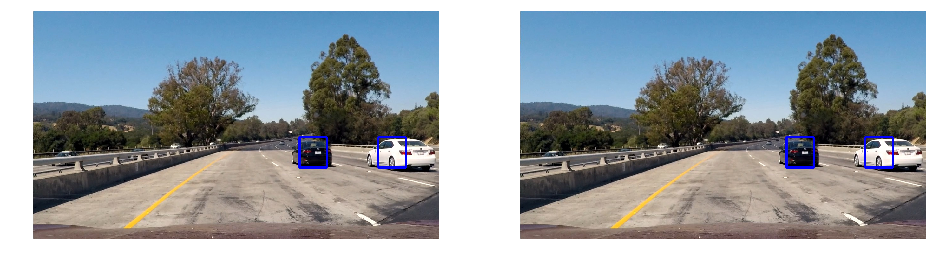

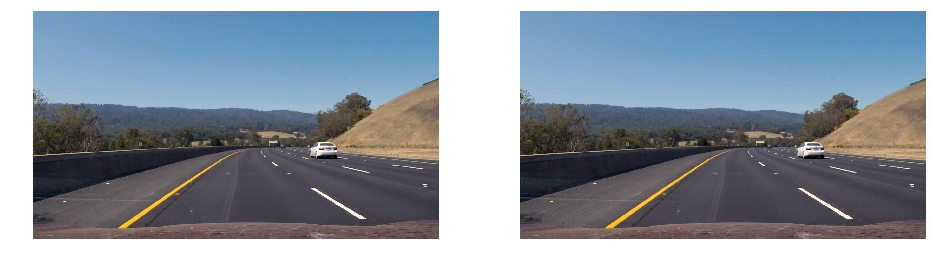

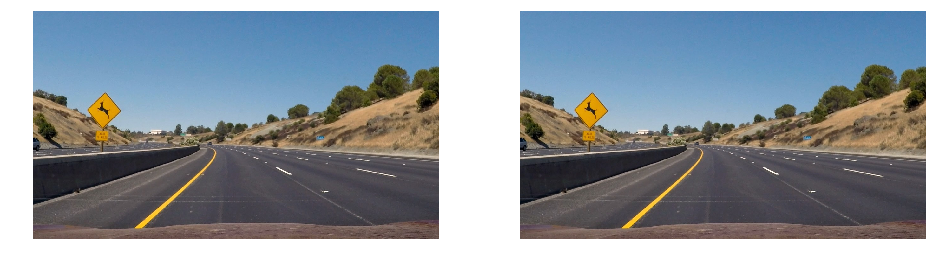

In [50]:
from glob import glob
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from model import Config
from utils import grid_display, _gray_to_RGB

test_images = glob('test_images/*.jpg')
output_images = []

svc = joblib.load('svc.joblib')
scaler = joblib.load('scaler.joblib')

cmap = plt.get_cmap('jet')

p2 = ProcessImage(False, 3)

for _image in test_images:
    _img5 = mpimg.imread(_image)
    
    output_images.append(_img5)
    output_images.append(
        p2.process(_img5)
    )
    

grid_display(output_images, no_of_columns=2, figsize=(16, 16))

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = './project_output.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video ./project_output.mp4
[MoviePy] Writing video ./project_output.mp4


100%|█████████▉| 1260/1261 [10:13<00:00,  2.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output.mp4 



In [49]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

p1 = ProcessImage(True, 5)
    
output = './test_vide_output.mp4'
clip1 = VideoFileClip('./test_video.mp4')
white_clip = clip1.fl_image(p1.process)
white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./test_vide_output.mp4
[MoviePy] Writing video ./test_vide_output.mp4


 97%|█████████▋| 38/39 [00:54<00:01,  1.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_vide_output.mp4 

